In [1]:
import numpy as np
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

In [2]:
#agnpy
import sys
sys.path.append("../")
from agnpy.emission_regions import Blob
from agnpy.synchrotron import Synchrotron
from agnpy.compton import SynchrotronSelfCompton

In [3]:
# gammapy
from gammapy.estimators import FluxPoints
from gammapy.datasets import FluxPointsDataset
from gammapy.modeling.models import SpectralModel, SkyModel
from gammapy.modeling import Parameter, Fit

In [4]:
# load the SED data
ecsv_tab = Table.read("data/sed_mrk421.ecsv")
fluxpoints_tab = Table() 
fluxpoints_tab["e_ref"] = ecsv_tab["x"].to("eV", equivalencies=u.spectral())
fluxpoints_tab["e2dnde"] = ecsv_tab["y"]
fluxpoints_tab["e2dnde_err"] = ecsv_tab["dy"]
fluxpoints_tab.meta['SED_TYPE'] = "e2dnde"
flux_points = FluxPoints(fluxpoints_tab)

In [5]:
# let's draw a tentative SED, before the fit
# blob definition
spectrum_norm = 1e48 * u.erg
parameters = {
        "p1": 2.0,
        "p2": 3.6,
        "gamma_b": 1e5,
        "gamma_min": 50,
        "gamma_max": 2e6,
}
spectrum_dict = {"type": "BrokenPowerLaw", "parameters": parameters}
R_b = 5e16 * u.cm
B = 0.1 * u.G
z = 0.03
delta_D = 10
Gamma = 10
blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)

* normalising BrokenPowerLaw in integral mode
normalising broken power-law to total energy density u_e: 1.91e-03 erg / cm3


../agnpy/compton.py:24: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


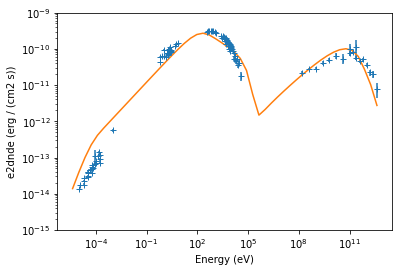

In [6]:
# synch and ssc radiation definition
synch = Synchrotron(blob)
ssc = SynchrotronSelfCompton(blob, synch)
nu = np.logspace(9, 27) * u.Hz
sed = synch.sed_flux(nu) + ssc.sed_flux(nu)

fig, ax = plt.subplots()
flux_points.plot(energy_unit="eV", ax=ax)
e = nu.to("eV", equivalencies=u.spectral())
ax.loglog(e, sed)
ax.set_ylim([1e-15, 1e-9])
plt.show()

In [7]:
class SSC(SpectralModel):
    """Spectral model with agnpy synchrotron self Compton Radiation and a broken power law of electrons
    """
    tag = "agnpySSC"
    spectrum_norm = Parameter(name="spectrum_norm", value=1, scale=1e48, unit="erg", min=1e-2, max=1e2)
    p1 = Parameter(name="p1", value=2.0, unit="", min=1.5, max=3.5)
    p2 = Parameter(name="p2", value=3.6, unit="", min=2, max=5)
    gamma_b = Parameter(name="gamma_b", value=1, scale=1e5, unit="", min=1e-2, max=1e2)
    B = Parameter(name="B", value=0.1, unit="G", min=0.01, max=10)

    def __init__(self, R_b, z, delta_D, Gamma, spectrum_norm, p1, p2, gamma_b, B):
        bpwl_parameters = {
            "p1": p1,
            "p2": p2,
            "gamma_b": gamma_b,
            "gamma_min": 50,
            "gamma_max": 2e6,
        }
        spectrum_dict = {"type": "BrokenPowerLaw", "parameters": bpwl_parameters}
        self.blob = Blob(R_b, z, delta_D, Gamma, B, spectrum_norm, spectrum_dict)
    
        super().__init__(specrtrum_norm=spectrum_norm, p1=p1, p2=p2, gamma_b=gamma_b, B=B)
    
    def evaluate(self, energy, spectrum_norm, p1, p2, gamma_b, B):
        # change the blob
        self.blob.spectrum_norm = spectrum_norm
        self.blob.n_e.p1 = p1
        self.blob.n_e.p2 = p2
        self.blob.n_e.gamma_b = gamma_b
        self.blob.B = B
        # recompute the radiation
        synch = Synchrotron(blob)
        ssc = SynchrotronSelfCompton(blob, synch)
        # convert to frequencies
        nu = energy.to("Hz", equivalencies = u.spectral())
        sed = synch.sed_flux(nu) + ssc.sed_flux(nu)
        
        return (sed / np.power(energy, 2)).to("erg-1 cm-2 s-1")

* normalising BrokenPowerLaw in integral mode
normalising broken power-law to total energy density u_e: 1.91e-03 erg / cm3


../agnpy/compton.py:24: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


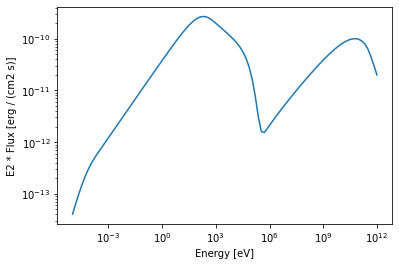

In [8]:
# spectral parameters
spectrum_norm = 1e48 * u.erg
p1 = 2.0
p2 = 3.6
gamma_b = 1e5

ssc_model = SSC(R_b, z, delta_D, Gamma, spectrum_norm, p1, p2, gamma_b, B)
ssc_model.plot(energy_range=[1e-5, 1e12] * u.eV, energy_power=2, energy_unit="eV", flux_unit="erg-1 cm-2 s-1")
plt.show()

In [9]:
# define the SkyModel and fit the FluxPoints
model = SkyModel(spectral_model=ssc_model)
dataset_ssc = FluxPointsDataset(model, flux_points.to_sed_type("dnde"))
fitter = Fit([dataset_ssc])
result_ssc = fitter.run()

../agnpy/compton.py:24: RuntimeWarning: invalid value encountered in log
  term_1 = 2 * q * np.log(q)


OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 16
	total stat : 64053211608416020632436736.00

SSC

     name       value   unit    min       max    frozen error
------------- --------- ---- --------- --------- ------ -----
spectrum_norm 1.000e+02  erg 1.000e-02 1.000e+02  False   nan
           p1 2.000e+00      1.500e+00 3.500e+00  False   nan
           p2 3.600e+00      2.000e+00 5.000e+00  False   nan
      gamma_b 1.000e+02      1.000e-02 1.000e+02  False   nan
            B 1.000e-01    G 1.000e-02 1.000e+01  False   nan


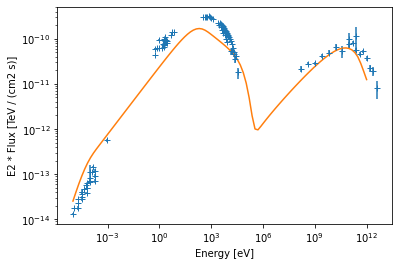

In [10]:
print(result_ssc)
print(ssc_model)

flux_points.plot(energy_unit="eV")
ssc_model.plot(energy_range=[1e-5, 1e12] * u.eV, energy_power=2, energy_unit="eV")
plt.show()